In [2]:
import HP_tuning as hp
import numpy as np
import matplotlib.pyplot as plt
import torch
from importlib import reload

In [3]:
reload(hp)

<module 'HP_tuning' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/HP_tuning.py'>

# Random search 
Optimize learning rate, tau and number of hidden layers and neurons for A2C with twin critics (both for critic and critic target).

In [4]:
# spans different magnitude scales, use logaritmic distribution for invariance of scale
lr_P_dict = dict(discrete=False,
                var_type='float',
                distribution='log',
                x_min = 1e-4,
                x_max = 1e-2)

# spans different magnitude scales, use logaritmic distribution for invariance of scale
tau_P_dict = dict(discrete=False,
                var_type='float',
                distribution='log',
                x_min = 1e-3,
                x_max = 1e-0)

In [5]:
possible_architectures = np.array([
                            [64,32,16],
                            [16,8,4],
                            [64,32],
                            [64,16],
                            [64,8],
                            [32,16],
                            [32,8],
                            [16,8],
                            [16,4],
                            [8,4]   
                        ])

probs = np.ones(10)/10

architecture_P_dict = dict(discrete=True,
                           var_type='str',
                           distribution='custom',
                           elements=possible_architectures,
                           p = probs)

In [6]:
P_dict = dict(lr=lr_P_dict, 
              tau=tau_P_dict,
              hiddens=architecture_P_dict)

n_samples = 15

params = {}
for key in P_dict.keys():
    P = hp.prior_distr(**P_dict[key])
    params[key] = P.sample(n_samples)
    
# now we make a list of dictionary instead of a dictionary of lists and we also add the last constant parameters
list_of_dict = []
for i in range(n_samples):
    d = {'TD' : True, 'twin' : True, 'gamma' : 0.99}
    for key in params.keys():
        d[key] = params[key][i]
    list_of_dict.append(d)

In [7]:
print("Number of combinations: ", len(list_of_dict))

def print_parameters(params):
    print("Parameters: ")
    print('='*75)
    for key in params:
        if (key == 'hiddens'):
            print(key, params[key])
        else:
            print(key, '\t', params[key])
    print('='*75)

def print_HP_score(params,score,dev):
    print_parameters(params)
    print("Score: %.4f +/- %.4f"%(score,dev))
    
flag = True #set to True to see all combinations
if flag == True:
    for params in list_of_dict:
        print()
        print_parameters(params)

Number of combinations:  15

Parameters: 
TD 	 True
twin 	 True
gamma 	 0.99
lr 	 0.004210682291470821
tau 	 0.012361217838012742
hiddens [32, 8]

Parameters: 
TD 	 True
twin 	 True
gamma 	 0.99
lr 	 0.0006656292525777889
tau 	 0.008649373404365503
hiddens [64, 8]

Parameters: 
TD 	 True
twin 	 True
gamma 	 0.99
lr 	 0.0024903530500309467
tau 	 0.21549016186146186
hiddens [64, 32, 16]

Parameters: 
TD 	 True
twin 	 True
gamma 	 0.99
lr 	 0.004914704701507579
tau 	 0.1790326176100507
hiddens [64, 32]

Parameters: 
TD 	 True
twin 	 True
gamma 	 0.99
lr 	 0.00192177768925518
tau 	 0.03770049060019448
hiddens [64, 32, 16]

Parameters: 
TD 	 True
twin 	 True
gamma 	 0.99
lr 	 0.00042817112639024
tau 	 0.04667462330500076
hiddens [16, 4]

Parameters: 
TD 	 True
twin 	 True
gamma 	 0.99
lr 	 0.000909006784486455
tau 	 0.0029416493515504348
hiddens [32, 16]

Parameters: 
TD 	 True
twin 	 True
gamma 	 0.99
lr 	 0.0005962493618188975
tau 	 0.029214798593471845
hiddens [64, 16]

Parameters: 
TD 	

In [8]:
save = True
n_runs = 10
n_episodes = 3000
HP_scores, HP_asymptotic_score, HP_asymptotic_std = hp.HP_Search(n_runs, n_episodes, list_of_dict)

if save:
    np.save("HP_scores", HP_scores)
    np.save("HP_asymptotic_score", HP_asymptotic_score)
    np.save("HP_asymptotic_std", HP_asymptotic_std)
    np.save("list_of_dict", list_of_dict)


Evaluating HP 1 / 15... 

Run 1/10: 
Episode 100 - reward: 21
Episode 200 - reward: 19
Episode 300 - reward: 24
Episode 400 - reward: 68
Episode 500 - reward: 83
Episode 600 - reward: 126
Episode 700 - reward: 137
Episode 800 - reward: 191
Episode 900 - reward: 165
Episode 1000 - reward: 205
Episode 1100 - reward: 163
Episode 1200 - reward: 188
Episode 1300 - reward: 249
Episode 1400 - reward: 133
Episode 1500 - reward: 269
Episode 1600 - reward: 163
Episode 1700 - reward: 133
Episode 1800 - reward: 132
Episode 1900 - reward: 157
Episode 2000 - reward: 151
Episode 2100 - reward: 185
Episode 2200 - reward: 189
Episode 2300 - reward: 267
Episode 2400 - reward: 176
Episode 2500 - reward: 219
Episode 2600 - reward: 143
Episode 2700 - reward: 127
Episode 2800 - reward: 113
Episode 2900 - reward: 124
Episode 3000 - reward: 116

Run 2/10: 
Episode 100 - reward: 18
Episode 200 - reward: 33
Episode 300 - reward: 104
Episode 400 - reward: 272
Episode 500 - reward: 276
Episode 600 - reward: 204


Episode 100 - reward: 20
Episode 200 - reward: 19
Episode 300 - reward: 17
Episode 400 - reward: 19
Episode 500 - reward: 21
Episode 600 - reward: 26
Episode 700 - reward: 34
Episode 800 - reward: 47
Episode 900 - reward: 54
Episode 1000 - reward: 85
Episode 1100 - reward: 124
Episode 1200 - reward: 140
Episode 1300 - reward: 156
Episode 1400 - reward: 150
Episode 1500 - reward: 150
Episode 1600 - reward: 143
Episode 1700 - reward: 140
Episode 1800 - reward: 142
Episode 1900 - reward: 152
Episode 2000 - reward: 163
Episode 2100 - reward: 155
Episode 2200 - reward: 143
Episode 2300 - reward: 126
Episode 2400 - reward: 131
Episode 2500 - reward: 133
Episode 2600 - reward: 156
Episode 2700 - reward: 158
Episode 2800 - reward: 151
Episode 2900 - reward: 169
Episode 3000 - reward: 171

Run 2/10: 
Episode 100 - reward: 20
Episode 200 - reward: 19
Episode 300 - reward: 20
Episode 400 - reward: 19
Episode 500 - reward: 19
Episode 600 - reward: 22
Episode 700 - reward: 37
Episode 800 - reward: 

Episode 100 - reward: 17
Episode 200 - reward: 38
Episode 300 - reward: 95
Episode 400 - reward: 172
Episode 500 - reward: 156
Episode 600 - reward: 98
Episode 700 - reward: 66
Episode 800 - reward: 124
Episode 900 - reward: 167
Episode 1000 - reward: 104
Episode 1100 - reward: 34
Episode 1200 - reward: 7
Episode 1300 - reward: 7
Episode 1400 - reward: 7
Episode 1500 - reward: 7
Episode 1600 - reward: 7
Episode 1700 - reward: 7
Episode 1800 - reward: 7
Episode 1900 - reward: 7
Episode 2000 - reward: 7
Episode 2100 - reward: 7
Episode 2200 - reward: 7
Episode 2300 - reward: 7
Episode 2400 - reward: 7
Episode 2500 - reward: 7
Episode 2600 - reward: 7
Episode 2700 - reward: 7
Episode 2800 - reward: 7
Episode 2900 - reward: 7
Episode 3000 - reward: 7

Run 2/10: 
Episode 100 - reward: 21
Episode 200 - reward: 61
Episode 300 - reward: 121
Episode 400 - reward: 127
Episode 500 - reward: 176
Episode 600 - reward: 239
Episode 700 - reward: 214
Episode 800 - reward: 214
Episode 900 - reward: 302

Episode 100 - reward: 21
Episode 200 - reward: 83
Episode 300 - reward: 290
Episode 400 - reward: 216
Episode 500 - reward: 170
Episode 600 - reward: 317
Episode 700 - reward: 500
Episode 800 - reward: 88
Episode 900 - reward: 56
Episode 1000 - reward: 85
Episode 1100 - reward: 7
Episode 1200 - reward: 7
Episode 1300 - reward: 7
Episode 1400 - reward: 7
Episode 1500 - reward: 7
Episode 1600 - reward: 7
Episode 1700 - reward: 7
Episode 1800 - reward: 7
Episode 1900 - reward: 17
Episode 2000 - reward: 340
Episode 2100 - reward: 25
Episode 2200 - reward: 32
Episode 2300 - reward: 42
Episode 2400 - reward: 54
Episode 2500 - reward: 67
Episode 2600 - reward: 133
Episode 2700 - reward: 120
Episode 2800 - reward: 67
Episode 2900 - reward: 58
Episode 3000 - reward: 133

Run 2/10: 
Episode 100 - reward: 20
Episode 200 - reward: 64
Episode 300 - reward: 149
Episode 400 - reward: 120
Episode 500 - reward: 112
Episode 600 - reward: 137
Episode 700 - reward: 176
Episode 800 - reward: 163
Episode 90

Episode 100 - reward: 19
Episode 200 - reward: 22
Episode 300 - reward: 105
Episode 400 - reward: 141
Episode 500 - reward: 209
Episode 600 - reward: 197
Episode 700 - reward: 138
Episode 800 - reward: 183
Episode 900 - reward: 266
Episode 1000 - reward: 171
Episode 1100 - reward: 203
Episode 1200 - reward: 304
Episode 1300 - reward: 195
Episode 1400 - reward: 203
Episode 1500 - reward: 200
Episode 1600 - reward: 190
Episode 1700 - reward: 296
Episode 1800 - reward: 259
Episode 1900 - reward: 207
Episode 2000 - reward: 150
Episode 2100 - reward: 200
Episode 2200 - reward: 109
Episode 2300 - reward: 108
Episode 2400 - reward: 88
Episode 2500 - reward: 98
Episode 2600 - reward: 78
Episode 2700 - reward: 90
Episode 2800 - reward: 91
Episode 2900 - reward: 90
Episode 3000 - reward: 201

Run 2/10: 
Episode 100 - reward: 20
Episode 200 - reward: 25
Episode 300 - reward: 124
Episode 400 - reward: 231
Episode 500 - reward: 173
Episode 600 - reward: 101
Episode 700 - reward: 140
Episode 800 - r

Episode 100 - reward: 20
Episode 200 - reward: 18
Episode 300 - reward: 17
Episode 400 - reward: 21
Episode 500 - reward: 21
Episode 600 - reward: 20
Episode 700 - reward: 20
Episode 800 - reward: 19
Episode 900 - reward: 17
Episode 1000 - reward: 19
Episode 1100 - reward: 21
Episode 1200 - reward: 21
Episode 1300 - reward: 22
Episode 1400 - reward: 19
Episode 1500 - reward: 21
Episode 1600 - reward: 21
Episode 1700 - reward: 19
Episode 1800 - reward: 19
Episode 1900 - reward: 20
Episode 2000 - reward: 20
Episode 2100 - reward: 23
Episode 2200 - reward: 21
Episode 2300 - reward: 20
Episode 2400 - reward: 22
Episode 2500 - reward: 23
Episode 2600 - reward: 22
Episode 2700 - reward: 19
Episode 2800 - reward: 20
Episode 2900 - reward: 20
Episode 3000 - reward: 21

Run 2/10: 
Episode 100 - reward: 13
Episode 200 - reward: 13
Episode 300 - reward: 13
Episode 400 - reward: 12
Episode 500 - reward: 13
Episode 600 - reward: 11
Episode 700 - reward: 11
Episode 800 - reward: 11
Episode 900 - rew

Episode 200 - reward: 15
Episode 300 - reward: 13
Episode 400 - reward: 14
Episode 500 - reward: 16
Episode 600 - reward: 16
Episode 700 - reward: 16
Episode 800 - reward: 23
Episode 900 - reward: 48
Episode 1000 - reward: 73
Episode 1100 - reward: 106
Episode 1200 - reward: 184
Episode 1300 - reward: 167
Episode 1400 - reward: 304
Episode 1500 - reward: 213
Episode 1600 - reward: 253
Episode 1700 - reward: 235
Episode 1800 - reward: 218
Episode 1900 - reward: 321
Episode 2000 - reward: 233
Episode 2100 - reward: 188
Episode 2200 - reward: 160
Episode 2300 - reward: 158
Episode 2400 - reward: 137
Episode 2500 - reward: 127
Episode 2600 - reward: 122
Episode 2700 - reward: 121
Episode 2800 - reward: 117
Episode 2900 - reward: 121
Episode 3000 - reward: 121

Run 2/10: 
Episode 100 - reward: 22
Episode 200 - reward: 20
Episode 300 - reward: 18
Episode 400 - reward: 21
Episode 500 - reward: 20
Episode 600 - reward: 26
Episode 700 - reward: 54
Episode 800 - reward: 71
Episode 900 - reward: 

Episode 100 - reward: 18
Episode 200 - reward: 18
Episode 300 - reward: 17
Episode 400 - reward: 18
Episode 500 - reward: 25
Episode 600 - reward: 44
Episode 700 - reward: 71
Episode 800 - reward: 153
Episode 900 - reward: 154
Episode 1000 - reward: 170
Episode 1100 - reward: 151
Episode 1200 - reward: 149
Episode 1300 - reward: 151
Episode 1400 - reward: 191
Episode 1500 - reward: 134
Episode 1600 - reward: 139
Episode 1700 - reward: 138
Episode 1800 - reward: 125
Episode 1900 - reward: 132
Episode 2000 - reward: 117
Episode 2100 - reward: 121
Episode 2200 - reward: 111
Episode 2300 - reward: 123
Episode 2400 - reward: 107
Episode 2500 - reward: 112
Episode 2600 - reward: 103
Episode 2700 - reward: 117
Episode 2800 - reward: 118
Episode 2900 - reward: 121
Episode 3000 - reward: 120

Run 2/10: 
Episode 100 - reward: 18
Episode 200 - reward: 17
Episode 300 - reward: 15
Episode 400 - reward: 16
Episode 500 - reward: 22
Episode 600 - reward: 33
Episode 700 - reward: 53
Episode 800 - rewar

Episode 100 - reward: 17
Episode 200 - reward: 16
Episode 300 - reward: 16
Episode 400 - reward: 17
Episode 500 - reward: 18
Episode 600 - reward: 17
Episode 700 - reward: 17
Episode 800 - reward: 17
Episode 900 - reward: 17
Episode 1000 - reward: 17
Episode 1100 - reward: 18
Episode 1200 - reward: 17
Episode 1300 - reward: 20
Episode 1400 - reward: 19
Episode 1500 - reward: 17
Episode 1600 - reward: 18
Episode 1700 - reward: 18
Episode 1800 - reward: 19
Episode 1900 - reward: 18
Episode 2000 - reward: 17
Episode 2100 - reward: 17
Episode 2200 - reward: 17
Episode 2300 - reward: 17
Episode 2400 - reward: 16
Episode 2500 - reward: 16
Episode 2600 - reward: 18
Episode 2700 - reward: 17
Episode 2800 - reward: 17
Episode 2900 - reward: 16
Episode 3000 - reward: 17

Run 2/10: 
Episode 100 - reward: 19
Episode 200 - reward: 18
Episode 300 - reward: 18
Episode 400 - reward: 18
Episode 500 - reward: 16
Episode 600 - reward: 17
Episode 700 - reward: 16
Episode 800 - reward: 17
Episode 900 - rew

Episode 100 - reward: 19
Episode 200 - reward: 20
Episode 300 - reward: 58
Episode 400 - reward: 115
Episode 500 - reward: 110
Episode 600 - reward: 141
Episode 700 - reward: 82
Episode 800 - reward: 66
Episode 900 - reward: 54
Episode 1000 - reward: 81
Episode 1100 - reward: 94
Episode 1200 - reward: 46
Episode 1300 - reward: 51
Episode 1400 - reward: 74
Episode 1500 - reward: 229
Episode 1600 - reward: 73
Episode 1700 - reward: 102
Episode 1800 - reward: 49
Episode 1900 - reward: 66
Episode 2000 - reward: 91
Episode 2100 - reward: 100
Episode 2200 - reward: 124
Episode 2300 - reward: 103
Episode 2400 - reward: 125
Episode 2500 - reward: 159
Episode 2600 - reward: 144
Episode 2700 - reward: 198
Episode 2800 - reward: 233
Episode 2900 - reward: 219
Episode 3000 - reward: 319

Run 2/10: 
Episode 100 - reward: 21
Episode 200 - reward: 21
Episode 300 - reward: 64
Episode 400 - reward: 108
Episode 500 - reward: 97
Episode 600 - reward: 107
Episode 700 - reward: 109
Episode 800 - reward: 11

Episode 100 - reward: 18
Episode 200 - reward: 19
Episode 300 - reward: 24
Episode 400 - reward: 28
Episode 500 - reward: 43
Episode 600 - reward: 59
Episode 700 - reward: 65
Episode 800 - reward: 92
Episode 900 - reward: 134
Episode 1000 - reward: 167
Episode 1100 - reward: 142
Episode 1200 - reward: 122
Episode 1300 - reward: 206
Episode 1400 - reward: 261
Episode 1500 - reward: 138
Episode 1600 - reward: 122
Episode 1700 - reward: 131
Episode 1800 - reward: 130
Episode 1900 - reward: 130
Episode 2000 - reward: 156
Episode 2100 - reward: 238
Episode 2200 - reward: 286
Episode 2300 - reward: 249
Episode 2400 - reward: 200
Episode 2500 - reward: 160
Episode 2600 - reward: 169
Episode 2700 - reward: 182
Episode 2800 - reward: 223
Episode 2900 - reward: 223
Episode 3000 - reward: 178

Run 2/10: 
Episode 100 - reward: 18
Episode 200 - reward: 20
Episode 300 - reward: 21
Episode 400 - reward: 28
Episode 500 - reward: 52
Episode 600 - reward: 83
Episode 700 - reward: 110
Episode 800 - rewar

Episode 100 - reward: 18
Episode 200 - reward: 19
Episode 300 - reward: 17
Episode 400 - reward: 16
Episode 500 - reward: 17
Episode 600 - reward: 16
Episode 700 - reward: 18
Episode 800 - reward: 16
Episode 900 - reward: 16
Episode 1000 - reward: 17
Episode 1100 - reward: 22
Episode 1200 - reward: 22
Episode 1300 - reward: 26
Episode 1400 - reward: 27
Episode 1500 - reward: 34
Episode 1600 - reward: 36
Episode 1700 - reward: 39
Episode 1800 - reward: 43
Episode 1900 - reward: 50
Episode 2000 - reward: 52
Episode 2100 - reward: 65
Episode 2200 - reward: 71
Episode 2300 - reward: 85
Episode 2400 - reward: 92
Episode 2500 - reward: 114
Episode 2600 - reward: 145
Episode 2700 - reward: 154
Episode 2800 - reward: 167
Episode 2900 - reward: 188
Episode 3000 - reward: 176

Run 2/10: 
Episode 100 - reward: 17
Episode 200 - reward: 18
Episode 300 - reward: 17
Episode 400 - reward: 18
Episode 500 - reward: 17
Episode 600 - reward: 17
Episode 700 - reward: 18
Episode 800 - reward: 21
Episode 900

Episode 100 - reward: 20
Episode 200 - reward: 19
Episode 300 - reward: 21
Episode 400 - reward: 23
Episode 500 - reward: 20
Episode 600 - reward: 20
Episode 700 - reward: 20
Episode 800 - reward: 18
Episode 900 - reward: 22
Episode 1000 - reward: 20
Episode 1100 - reward: 20
Episode 1200 - reward: 21
Episode 1300 - reward: 20
Episode 1400 - reward: 22
Episode 1500 - reward: 23
Episode 1600 - reward: 23
Episode 1700 - reward: 33
Episode 1800 - reward: 37
Episode 1900 - reward: 47
Episode 2000 - reward: 52
Episode 2100 - reward: 57
Episode 2200 - reward: 58
Episode 2300 - reward: 55
Episode 2400 - reward: 65
Episode 2500 - reward: 63
Episode 2600 - reward: 64
Episode 2700 - reward: 66
Episode 2800 - reward: 71
Episode 2900 - reward: 79
Episode 3000 - reward: 80

Run 2/10: 
Episode 100 - reward: 16
Episode 200 - reward: 15
Episode 300 - reward: 17
Episode 400 - reward: 17
Episode 500 - reward: 15
Episode 600 - reward: 16
Episode 700 - reward: 17
Episode 800 - reward: 16
Episode 900 - rew

Episode 100 - reward: 19
Episode 200 - reward: 18
Episode 300 - reward: 20
Episode 400 - reward: 16
Episode 500 - reward: 16
Episode 600 - reward: 16
Episode 700 - reward: 19
Episode 800 - reward: 23
Episode 900 - reward: 25
Episode 1000 - reward: 31
Episode 1100 - reward: 38
Episode 1200 - reward: 48
Episode 1300 - reward: 63
Episode 1400 - reward: 137
Episode 1500 - reward: 143
Episode 1600 - reward: 141
Episode 1700 - reward: 141
Episode 1800 - reward: 147
Episode 1900 - reward: 148
Episode 2000 - reward: 135
Episode 2100 - reward: 134
Episode 2200 - reward: 148
Episode 2300 - reward: 137
Episode 2400 - reward: 168
Episode 2500 - reward: 191
Episode 2600 - reward: 220
Episode 2700 - reward: 252
Episode 2800 - reward: 225
Episode 2900 - reward: 238
Episode 3000 - reward: 198

Run 2/10: 
Episode 100 - reward: 16
Episode 200 - reward: 19
Episode 300 - reward: 16
Episode 400 - reward: 15
Episode 500 - reward: 16
Episode 600 - reward: 18
Episode 700 - reward: 17
Episode 800 - reward: 19


Episode 100 - reward: 20
Episode 200 - reward: 18
Episode 300 - reward: 18
Episode 400 - reward: 21
Episode 500 - reward: 21
Episode 600 - reward: 21
Episode 700 - reward: 24
Episode 800 - reward: 27
Episode 900 - reward: 37
Episode 1000 - reward: 44
Episode 1100 - reward: 51
Episode 1200 - reward: 59
Episode 1300 - reward: 76
Episode 1400 - reward: 86
Episode 1500 - reward: 95
Episode 1600 - reward: 163
Episode 1700 - reward: 122
Episode 1800 - reward: 127
Episode 1900 - reward: 162
Episode 2000 - reward: 200
Episode 2100 - reward: 207
Episode 2200 - reward: 223
Episode 2300 - reward: 237
Episode 2400 - reward: 228
Episode 2500 - reward: 223
Episode 2600 - reward: 223
Episode 2700 - reward: 237
Episode 2800 - reward: 233
Episode 2900 - reward: 235
Episode 3000 - reward: 259

Run 2/10: 
Episode 100 - reward: 18
Episode 200 - reward: 18
Episode 300 - reward: 21
Episode 400 - reward: 21
Episode 500 - reward: 22
Episode 600 - reward: 23
Episode 700 - reward: 21
Episode 800 - reward: 23
Ep

# Evaluation

In [24]:
HP_scores = np.load("Results/HP_scores.npy")
HP_asymptotic_score = np.load("Results/HP_asymptotic_score.npy")
HP_asymptotic_std = np.load("Results/HP_asymptotic_std.npy")
list_of_dict = np.load("Results/list_of_dict.npy", allow_pickle=True)

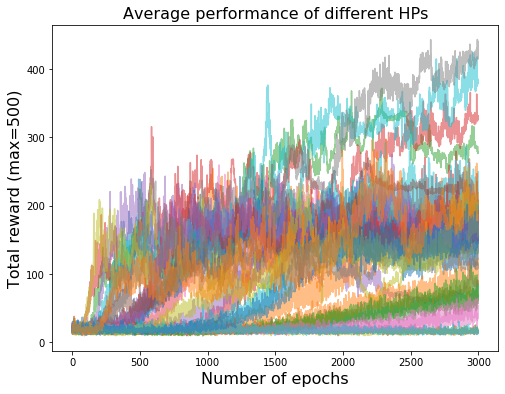

In [32]:
plt.figure(figsize=(8,6))
n_epochs = np.arange(HP_scores.shape[2])
for i in range(len(HP_scores)):
    plt.plot(n_epochs, HP_scores[i].mean(axis=0), alpha=0.5)
plt.title("Average performance of different HPs", fontsize=16)
plt.xlabel("Number of epochs", fontsize=16)
plt.ylabel("Total reward (max=500)", fontsize=16)
plt.show()

In [34]:
final_score = HP_asymptotic_score - 3*HP_asymptotic_std # conservative score

In [36]:
best = np.argmax(final_score)

In [37]:
best_HPs = list_of_dict[best]

In [38]:
best_HPs

{'TD': True,
 'twin': True,
 'gamma': 0.99,
 'lr': 0.0026084258104866393,
 'tau': 0.1970007316506616,
 'hiddens': [32, 16]}

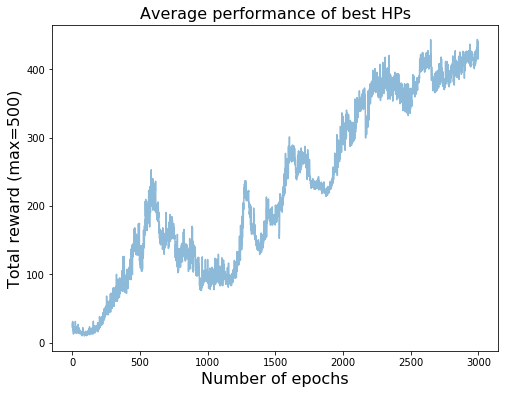

In [39]:
plt.figure(figsize=(8,6))
n_epochs = np.arange(HP_scores.shape[2])
plt.plot(n_epochs, HP_scores[best].mean(axis=0), alpha=0.5)
plt.title("Average performance of best HPs", fontsize=16)
plt.xlabel("Number of epochs", fontsize=16)
plt.ylabel("Total reward (max=500)", fontsize=16)
plt.show()

As we can see, after 3000 epochs the average is still increasing, so in the real evaluation we will try with more epochs (e.g. 5000).

But before going on and analyse with those parameters the influence of the twin networks, of the exponential moving average and the temporal difference learning w.r.t. the Monte Carlo one, I'm going to see how the 3 HPs tuned so far influence the performance.

In [54]:
learning_rates = []
taus = []
tot_neurons = []
first_hidden = []

for i in range(len(list_of_dict)):
    learning_rates.append(list_of_dict[i]['lr'])
    taus.append(list_of_dict[i]['tau'])
    tot_n = np.sum(list_of_dict[i]['hiddens'])
    tot_neurons.append(tot_n)
    first = list_of_dict[i]['hiddens'][0]
    first_hidden.append(first)

### Learning rate

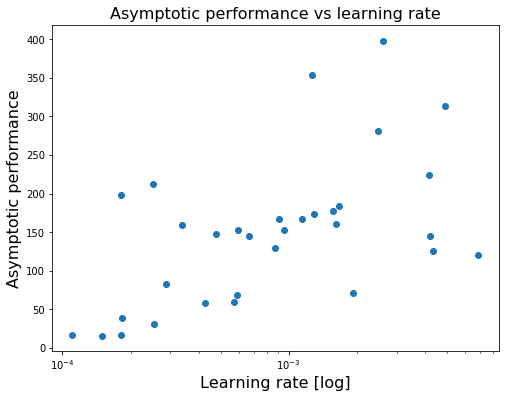

In [50]:
plt.figure(figsize=(8,6))
plt.errorbar(learning_rates, HP_asymptotic_score, yerr= HP_asymptotic_std, fmt='o')
plt.xscale('log')
plt.title("Asymptotic performance vs learning rate", fontsize=16)
plt.xlabel("Learning rate [log]", fontsize=16)
plt.ylabel("Asymptotic performance", fontsize=16)
plt.show()

There is a trend showing that higher learning rates on average scored better than lower ones, but also there is a lot of variability due to the other 2 variables that we changed.

### Tau

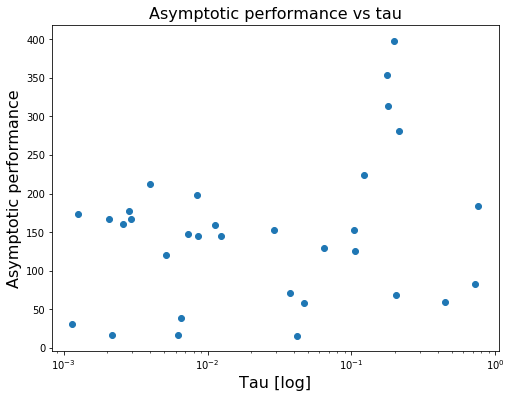

In [52]:
plt.figure(figsize=(8,6))
plt.errorbar(taus, HP_asymptotic_score, yerr= HP_asymptotic_std, fmt='o')
plt.xscale('log')
plt.title("Asymptotic performance vs tau", fontsize=16)
plt.xlabel("Tau [log]", fontsize=16)
plt.ylabel("Asymptotic performance", fontsize=16)
plt.show()

Similar to before there seem to be a trend in which higher $\tau$ imply lower performances, but there are some significant outlayers performing much better than any other configuration even though they have very high $\tau$s. This means that there are more fundamental parameters of the model.

### Total number of hidden neurons

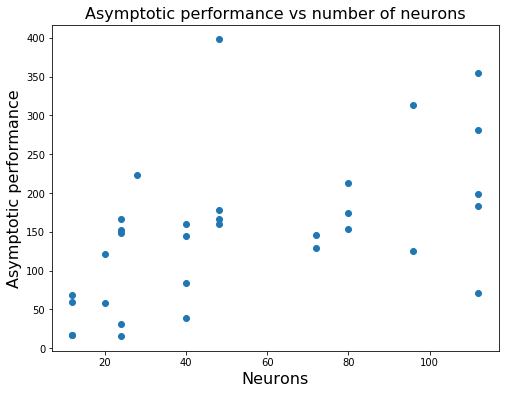

In [53]:
plt.figure(figsize=(8,6))
plt.plot(tot_neurons, HP_asymptotic_score, 'o')
plt.title("Asymptotic performance vs number of neurons", fontsize=16)
plt.xlabel("Neurons", fontsize=16)
plt.ylabel("Asymptotic performance", fontsize=16)
plt.show()

The trend here shows that in general greater architectures ([64,32,16]) are better than smaller ([8,4]), thus even the greatest ones are not that great to overfit the problem.

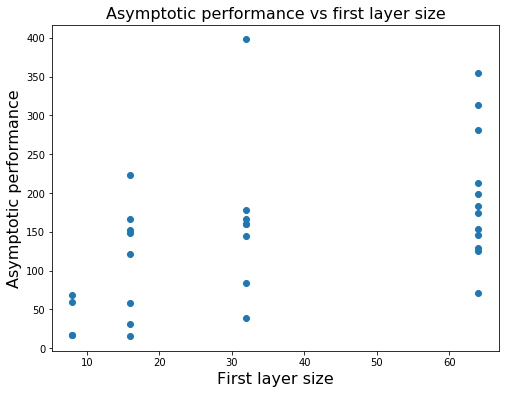

In [56]:
plt.figure(figsize=(8,6))
plt.plot(first_hidden, HP_asymptotic_score, 'o')
plt.title("Asymptotic performance vs first layer size", fontsize=16)
plt.xlabel("First layer size", fontsize=16)
plt.ylabel("Asymptotic performance", fontsize=16)
plt.show()

# Evaluating final models

Models:
* TD or MC
* twin critics or not
* exponential moving average for targets (only in TD case) or not

Thus we have 4 combinations for TD and 2 for MC.

In [58]:
import copy
list_of_models = []

#1: (TD, twin, moving)
list_of_models.append(best_HPs)

#2: (TD, twin, hard)
d = copy.deepcopy(best_HPs)
d['tau'] = 1. 
list_of_models.append(d)

#3: (TD, single, moving)
d = copy.deepcopy(best_HPs)
d['twin'] = False 
list_of_models.append(d)

#4: (TD, single, hard)
d = copy.deepcopy(best_HPs)
d['tau'] = 1. 
d['twin'] = False 
list_of_models.append(d)

#5: (MC, single, hard) 
# tau is not used if TD=False
d = copy.deepcopy(best_HPs)
d['TD'] = False
d['twin'] = False 
list_of_models.append(d)

#6: (MC, twin, hard) 
# tau is not used if TD=False
d = copy.deepcopy(best_HPs)
d['TD'] = False
d['twin'] = True 
list_of_models.append(d)

In [ ]:
train = False
if train:
    save = True
    n_runs = 10
    n_episodes = 5000
    HP_scores, HP_asymptotic_score, HP_asymptotic_std = hp.HP_Search(n_runs, n_episodes, list_of_models)

    if save:
        np.save(parent_dir+"/model_scores", HP_scores)
        np.save(parent_dir+"/model_asymptotic_score", HP_asymptotic_score)
        np.save(parent_dir+"/model_asymptotic_std", HP_asymptotic_std)
        np.save(parent_dir+"/list_of_models", list_of_models)